In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import pickle
import time
import warnings

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
warnings.filterwarnings('ignore')

2025-10-25 22:25:22.928336: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761431123.120587      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761431123.177812      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
BASE_PATH_EXP1 = '/kaggle/input/hybridvfl-exp-1/'
BASE_PATH_EXP2 = '/kaggle/input/hybridvfl-exp-2/'

# Debug: Check if datasets exist
import os
print(f"Exp1 dataset exists: {os.path.exists(BASE_PATH_EXP1)}")
print(f"Exp2 dataset exists: {os.path.exists(BASE_PATH_EXP2)}")

if os.path.exists(BASE_PATH_EXP2):
    print(f"Exp2 contents: {os.listdir(BASE_PATH_EXP2)}")
else:
    print("Exp2 dataset not found. Please ensure hybridvfl-exp-2 dataset is added to this notebook.")

image_model = load_model(BASE_PATH_EXP1 + 'best_image_model.keras')

X_train = np.load(BASE_PATH_EXP1 + 'X_train.npy')
X_test = np.load(BASE_PATH_EXP1 + 'X_test.npy')
y_train = np.load(BASE_PATH_EXP1 + 'y_train.npy')
y_test = np.load(BASE_PATH_EXP1 + 'y_test.npy')

train_tabular_features = np.load(BASE_PATH_EXP2 + 'train_tabular_features.npy')
test_tabular_features = np.load(BASE_PATH_EXP2 + 'test_tabular_features.npy')

with open(BASE_PATH_EXP1 + 'class_weight_dict.pkl', 'rb') as f:
    class_weight_dict = pickle.load(f)

with open(BASE_PATH_EXP2 + 'exp1_2_results.pkl', 'rb') as f:
    prev_results = pickle.load(f)

Exp1 dataset exists: True
Exp2 dataset exists: True
Exp2 contents: ['exp1_2_results.pkl', 'tabular_scaler.pkl', 'train_tabular_features.npy', 'test_tabular_features.npy', 'best_multimodal_model.keras', 'exp2_results.pkl']


I0000 00:00:1761431136.769795      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [3]:
if hasattr(image_model, 'input') and image_model.input is not None:
    model_input = image_model.input
else:
    model_input = image_model.layers[0].input

feature_layer = None
for layer in image_model.layers:
    if isinstance(layer, tf.keras.layers.MaxPooling2D):
        feature_layer = layer
        if 'max_pooling2d_2' in layer.name:
            break

if feature_layer is None or 'max_pooling2d_2' not in feature_layer.name:
    maxpool_layers = [layer for layer in image_model.layers if isinstance(layer, tf.keras.layers.MaxPooling2D)]
    if len(maxpool_layers) >= 2:
        feature_layer = maxpool_layers[1]
    else:
        feature_layer = maxpool_layers[0]

image_client_model = Model(
    inputs=model_input,
    outputs=feature_layer.output,
    name='ImageClient'
)

for layer in image_client_model.layers[:-2]:
    layer.trainable = False

In [4]:
tabular_input = Input(shape=(train_tabular_features.shape[1],), name='tabular_input')
x_tab = Dense(64, activation='relu', name='tabular_dense1')(tabular_input)
x_tab = Dropout(0.3, name='tabular_dropout1')(x_tab)
tabular_output = Dense(32, activation='relu', name='tabular_dense2')(x_tab)

tabular_client_model = Model(
    inputs=tabular_input,
    outputs=tabular_output,
    name='TabularClient'
)

In [5]:
image_embedding_input = Input(shape=(np.prod(image_client_model.output_shape[1:]),), name='server_image_input')
tabular_embedding_input = Input(shape=(tabular_client_model.output_shape[1],), name='server_tabular_input')

concat_embeddings = Concatenate(name='server_concat')([image_embedding_input, tabular_embedding_input])

x_server = Dense(64, activation='relu', name='server_fc1')(concat_embeddings)
x_server = Dropout(0.7, name='server_dropout1')(x_server)
x_server = Dense(32, activation='relu', name='server_fc2')(x_server)
x_server = Dropout(0.6, name='server_dropout2')(x_server)
server_output = Dense(7, activation='softmax', name='server_output')(x_server)

server_model = Model(
    inputs=[image_embedding_input, tabular_embedding_input],
    outputs=server_output,
    name='ServerModel'
)

optimizer_image = Adam(learning_rate=0.00005)
optimizer_tabular = Adam(learning_rate=0.00005)
optimizer_server = Adam(learning_rate=0.00005)

server_model.compile(
    optimizer=optimizer_server,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [6]:
VFL_EPOCHS = 50
VFL_BATCH_SIZE = 32

num_train_samples = len(X_train)
num_batches = num_train_samples // VFL_BATCH_SIZE

vfl3_train_loss_history = []
vfl3_train_acc_history = []
vfl3_val_loss_history = []
vfl3_val_acc_history = []
vfl3_comm_costs_upload = []
vfl3_comm_costs_download = []

best_val_acc = 0
patience_counter = 0
EARLY_STOP_PATIENCE = 15
best_weights = None

lr_patience_counter = 0
LR_REDUCE_PATIENCE = 2
current_lr = 0.00005
LR_REDUCE_FACTOR = 0.5
MIN_LR = 1e-7

vfl3_start_time = time.time()

print("Training Progress:")
for epoch in range(VFL_EPOCHS):
    epoch_start = time.time()
    epoch_loss = 0
    epoch_acc = 0
    epoch_upload_cost = 0
    epoch_download_cost = 0
    
    indices = np.random.permutation(num_train_samples)
    
    for batch_idx in range(num_batches):
        batch_start = batch_idx * VFL_BATCH_SIZE
        batch_end = batch_start + VFL_BATCH_SIZE
        batch_indices = indices[batch_start:batch_end]
        
        X_batch = X_train[batch_indices]
        y_batch = y_train[batch_indices]
        X_tab_batch = train_tabular_features[batch_indices]
        
        with tf.GradientTape(persistent=True) as client_tape:
            image_embeddings = image_client_model(X_batch, training=True)
            image_embeddings_flat = tf.reshape(image_embeddings, [VFL_BATCH_SIZE, -1])
            tabular_embeddings = tabular_client_model(X_tab_batch, training=True)
        
        upload_cost = (image_embeddings_flat.numpy().nbytes + tabular_embeddings.numpy().nbytes) / (1024 * 1024)
        epoch_upload_cost += upload_cost
        
        with tf.GradientTape(persistent=True) as server_tape:
            predictions = server_model([image_embeddings_flat, tabular_embeddings], training=True)
            sample_weights = np.array([class_weight_dict[np.argmax(y)] for y in y_batch])
            loss = tf.keras.losses.categorical_crossentropy(y_batch, predictions)
            loss = tf.reduce_mean(loss * sample_weights)
        
        server_grads = server_tape.gradient(loss, server_model.trainable_variables)
        optimizer_server.apply_gradients(zip(server_grads, server_model.trainable_variables))
        
        grad_image_input = server_tape.gradient(loss, image_embeddings_flat)
        grad_tabular_input = server_tape.gradient(loss, tabular_embeddings)
        
        del server_tape
        
        download_size = 0
        if grad_image_input is not None:
            download_size += grad_image_input.numpy().nbytes
        if grad_tabular_input is not None:
            download_size += grad_tabular_input.numpy().nbytes
        download_cost = download_size / (1024 * 1024)
        epoch_download_cost += download_cost
        
        if grad_image_input is not None:
            image_grads = client_tape.gradient(image_embeddings_flat, image_client_model.trainable_variables,
                                               output_gradients=grad_image_input)
            if image_grads and any(g is not None for g in image_grads):
                optimizer_image.apply_gradients(zip([g for g in image_grads if g is not None],
                                                    [v for v, g in zip(image_client_model.trainable_variables, image_grads) if g is not None]))
        
        if grad_tabular_input is not None:
            tabular_grads = client_tape.gradient(tabular_embeddings, tabular_client_model.trainable_variables,
                                                 output_gradients=grad_tabular_input)
            if tabular_grads and any(g is not None for g in tabular_grads):
                optimizer_tabular.apply_gradients(zip([g for g in tabular_grads if g is not None],
                                                      [v for v, g in zip(tabular_client_model.trainable_variables, tabular_grads) if g is not None]))
        
        del client_tape
        
        epoch_loss += loss.numpy()
        batch_acc = np.mean(np.argmax(predictions.numpy(), axis=1) == np.argmax(y_batch, axis=1))
        epoch_acc += batch_acc
    
    avg_loss = epoch_loss / num_batches
    avg_acc = epoch_acc / num_batches
    
    val_image_emb = image_client_model.predict(X_test, verbose=0)
    val_image_emb_flat = val_image_emb.reshape(len(X_test), -1)
    val_tabular_emb = tabular_client_model.predict(test_tabular_features, verbose=0)
    val_predictions = server_model.predict([val_image_emb_flat, val_tabular_emb], verbose=0)
    val_loss = tf.keras.losses.categorical_crossentropy(y_test, val_predictions).numpy().mean()
    val_acc = np.mean(np.argmax(val_predictions, axis=1) == np.argmax(y_test, axis=1))
    
    vfl3_train_loss_history.append(avg_loss)
    vfl3_train_acc_history.append(avg_acc)
    vfl3_val_loss_history.append(val_loss)
    vfl3_val_acc_history.append(val_acc)
    vfl3_comm_costs_upload.append(epoch_upload_cost)
    vfl3_comm_costs_download.append(epoch_download_cost)
    
    # Print epoch progress
    print(f"Epoch {epoch+1}/{VFL_EPOCHS} - loss: {avg_loss:.4f} - acc: {avg_acc:.4f} - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        lr_patience_counter = 0
        best_weights = [w.numpy() for w in server_model.weights]
        best_img_weights = [w.numpy() for w in image_client_model.weights]
        best_tab_weights = [w.numpy() for w in tabular_client_model.weights]
    else:
        patience_counter += 1
        lr_patience_counter += 1
        
        if lr_patience_counter >= LR_REDUCE_PATIENCE and current_lr > MIN_LR:
            current_lr = max(current_lr * LR_REDUCE_FACTOR, MIN_LR)
            optimizer_server.learning_rate.assign(current_lr)
            optimizer_image.learning_rate.assign(current_lr)
            optimizer_tabular.learning_rate.assign(current_lr)
            lr_patience_counter = 0
    
    if patience_counter >= EARLY_STOP_PATIENCE:
        if best_weights is not None:
            for w, best_w in zip(server_model.weights, best_weights):
                w.assign(best_w)
            for w, best_w in zip(image_client_model.weights, best_img_weights):
                w.assign(best_w)
            for w, best_w in zip(tabular_client_model.weights, best_tab_weights):
                w.assign(best_w)
        break

vfl3_total_time = time.time() - vfl3_start_time

image_client_model.save('/kaggle/working/exp3_image_client.keras')
tabular_client_model.save('/kaggle/working/exp3_tabular_client.keras')
server_model.save('/kaggle/working/exp3_server.keras')

Training Progress:


I0000 00:00:1761431145.436230      20 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1761431210.818229      58 service.cc:148] XLA service 0x7dce28002d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761431210.818929      58 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1761431211.541853      58 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1/50 - loss: 2.3796 - acc: 0.1611 - val_loss: 1.8710 - val_acc: 0.2801
Epoch 2/50 - loss: 1.9315 - acc: 0.1996 - val_loss: 1.8436 - val_acc: 0.3350
Epoch 3/50 - loss: 1.8735 - acc: 0.2566 - val_loss: 1.7905 - val_acc: 0.4397
Epoch 4/50 - loss: 1.8177 - acc: 0.3118 - val_loss: 1.7267 - val_acc: 0.4504
Epoch 5/50 - loss: 1.7653 - acc: 0.3205 - val_loss: 1.6686 - val_acc: 0.4668
Epoch 6/50 - loss: 1.7154 - acc: 0.3385 - val_loss: 1.6163 - val_acc: 0.4952
Epoch 7/50 - loss: 1.6630 - acc: 0.3587 - val_loss: 1.5521 - val_acc: 0.5174
Epoch 8/50 - loss: 1.6133 - acc: 0.3746 - val_loss: 1.4960 - val_acc: 0.5174
Epoch 9/50 - loss: 1.5536 - acc: 0.3940 - val_loss: 1.4090 - val_acc: 0.5381
Epoch 10/50 - loss: 1.5159 - acc: 0.4089 - val_loss: 1.3664 - val_acc: 0.5567
Epoch 11/50 - loss: 1.4737 - acc: 0.4215 - val_loss: 1.3180 - val_acc: 0.5863
Epoch 12/50 - loss: 1.4283 - acc: 0.4355 - val_loss: 1.2894 - val_acc: 0.6083
Epoch 13/50 - loss: 1.3954 - acc: 0.4471 - val_loss: 1.2451 - val_acc: 0.

In [7]:
test_image_emb = image_client_model.predict(X_test, verbose=0)
test_image_emb_flat = test_image_emb.reshape(len(X_test), -1)
test_tabular_emb = tabular_client_model.predict(test_tabular_features, verbose=0)
test_predictions = server_model.predict([test_image_emb_flat, test_tabular_emb], verbose=0)

y_pred = np.argmax(test_predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

test_acc = accuracy_score(y_true, y_pred)
balanced_acc = balanced_accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average='macro')
macro_precision = precision_score(y_true, y_pred, average='macro')
macro_recall = recall_score(y_true, y_pred, average='macro')

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")

Test Accuracy: 0.6960
Balanced Accuracy: 0.7766
Macro F1: 0.7318
Macro Precision: 0.7123
Macro Recall: 0.7766


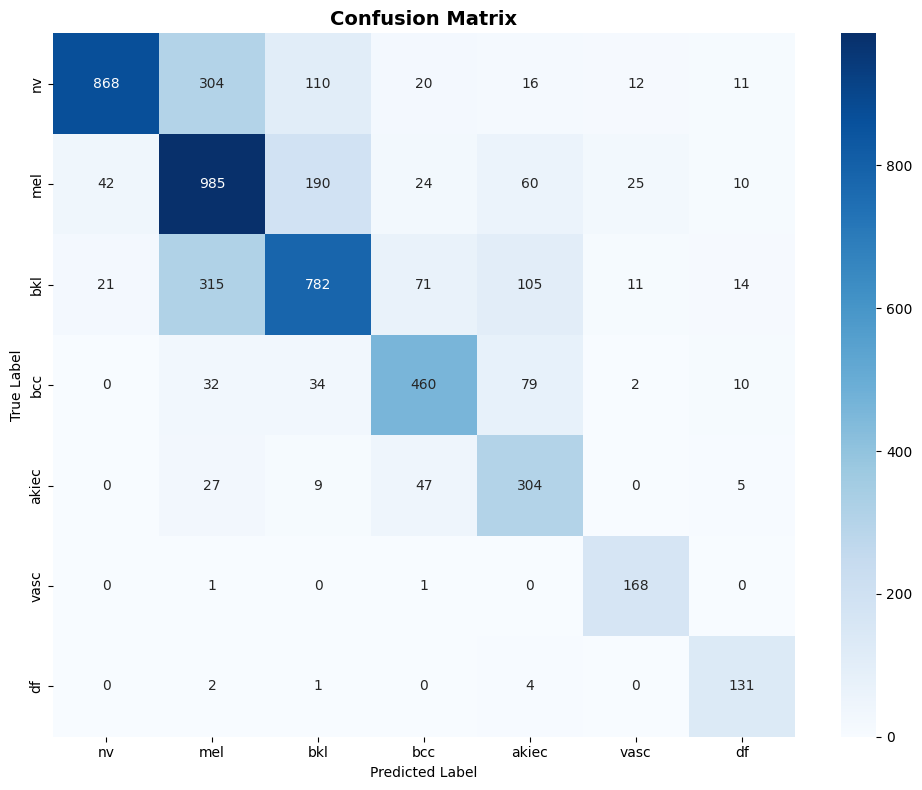

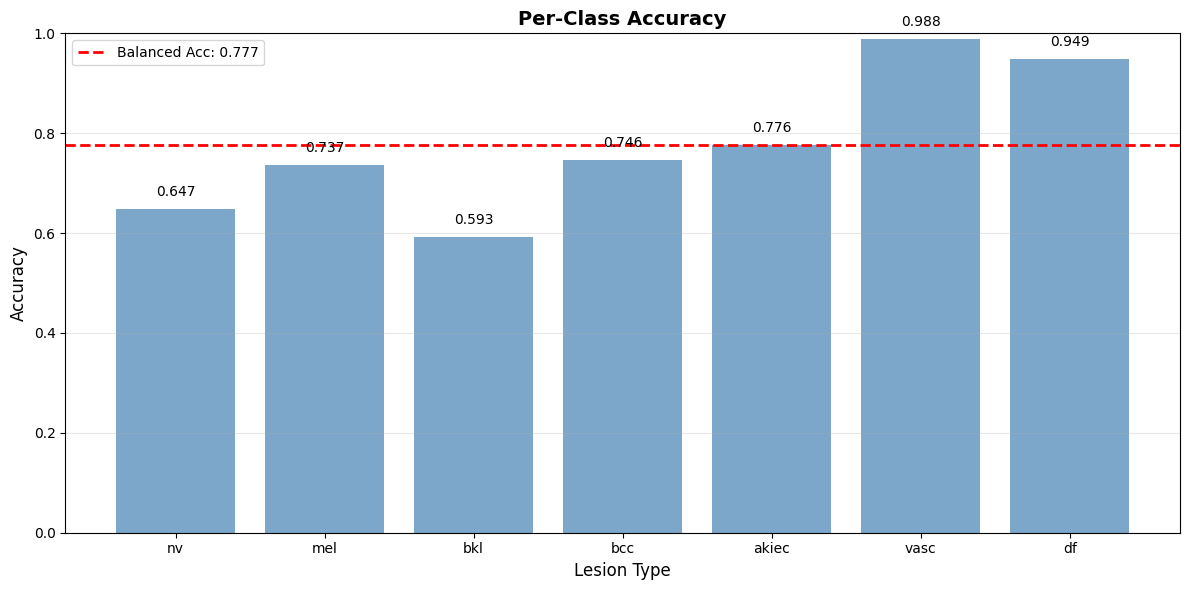

In [8]:
lesion_types = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=lesion_types, yticklabels=lesion_types)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('/kaggle/working/exp3_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

per_class_acc = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(12, 6))
bars = plt.bar(lesion_types, per_class_acc, color='steelblue', alpha=0.7)
plt.axhline(y=balanced_acc, color='red', linestyle='--', linewidth=2,
            label=f'Balanced Acc: {balanced_acc:.3f}')
plt.xlabel('Lesion Type', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Per-Class Accuracy', fontsize=14, fontweight='bold')
plt.ylim([0, 1])
plt.legend()
plt.grid(axis='y', alpha=0.3)
for bar, acc in zip(bars, per_class_acc):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02, f'{acc:.3f}',
             ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.savefig('/kaggle/working/exp3_per_class_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
exp3_results = {
    'test_accuracy': float(test_acc),
    'balanced_accuracy': float(balanced_acc),
    'confusion_matrix': cm,
    'training_history': {
        'loss': vfl3_train_loss_history,
        'acc': vfl3_train_acc_history,
        'val_loss': vfl3_val_loss_history,
        'val_acc': vfl3_val_acc_history,
        'comm_upload': vfl3_comm_costs_upload,
        'comm_download': vfl3_comm_costs_download
    },
    'per_class_accuracy': per_class_acc.tolist(),
    'predictions': y_pred,
    'training_time_minutes': vfl3_total_time / 60,
    'architecture': 'vfl_baseline'
}

with open('/kaggle/working/exp3_results.pkl', 'wb') as f:
    pickle.dump(exp3_results, f)